## Analyzing Traveler Experiences

In [35]:
from IPython.display import Image, display

# Replace 'url' with the actual URL of the image
url = "https://download.logo.wine/logo/Kenya_Airways/Kenya_Airways-Logo.wine.png"

display(Image(url=url, width=400, height=300))


This notebook analyzes customer reviews from SKYTRAX (https://www.airlinequality.com/) focusing on Kenya Airways. It uncovers dominant discussion topics and measures overall satisfaction, providing insights into passengers' experiences.

## Table of Contents
1. [Data scraping](#1)<br>
2. [Data cleaning](#2)<br>
3. [Tokenization](#3)<br>
4. [Removing stopwords](#4)<br>
5. [Data analysis](#5)<br>
   5.1. [Word count](#5.1)<br>
   5.2. [Results](#5.2)<br>

In [36]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

## <span class="anchor" id="1">1. Data Scraping</span>

The data scraped for this analysis pertains to Kenya Airways, but the code can be easily adapted to work with reviews from any other airline as well.

In [37]:
base_url = "https://www.airlinequality.com/airline-reviews/kenya-airways"
# base_url = "https://www.airlinequality.com/airline-reviews/emirates"
# base_url = "https://www.airlinequality.com/airline-reviews/qatar-airways"
# base_url = "https://www.airlinequality.com/airline-reviews/etihad-airways"

pages = 10
page_size = 1000

reviews = []

for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    # print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
Scraping page 2
Scraping page 3
Scraping page 4
Scraping page 5
Scraping page 6
Scraping page 7
Scraping page 8
Scraping page 9
Scraping page 10


In [38]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | Dismal from start to end. N...
1,Not Verified | Airline was 1 hour late to boar...
2,✅ Trip Verified | Kenya Airways has really di...
3,✅ Trip Verified | JNB-NBO-AMS-ZRH on 14-15 Au...
4,✅ Trip Verified | Officially the worlds worst ...


In [39]:
# df.to_csv("..../KA_reviews.csv")

In [40]:
df.shape

(433, 1)

The loops above collected 433 reviews by iterating through the paginated pages on the website. 

The next thing would be to remove unverified reviews. However, since the resulting dataset will be smaller, we choose to skip this step and proceed with the current dataset.

In [41]:
# filter the rows that are Trip Verified
# df = df[df['reviews'].str.contains('Trip Verified')]
# df.size

## <span class="anchor" id="2">2. Data cleaning</span>

In [42]:
# Remove the string "Trip Verified" and "Not Verified" from the "words" column of the DataFrame
df['reviews'] = df['reviews'].str.replace('Trip Verified', '')
df['reviews'] = df['reviews'].str.replace('Not Verified', '')
# Remove the ✅ and | characters 
df['reviews'] = df['reviews'].str.replace('[✅|]', '', regex=True)
df.head(3)

,reviews
0,Dismal from start to end. Not all of the s...
1,Airline was 1 hour late to board passengers ...
2,Kenya Airways has really disappointed me f...


The code snippet above removes the phrases "Trip Verified" and "Not Verified" phrases, as well as the characters ✅ and | as they do not contribute meaningful value to the analysis.

## <span class="anchor" id="3">3. Tokenization</span>

Tokenization involves dividing a given text, whether it's a phrase, sentence, paragraph, or entire document, into smaller units known as tokens. Tokenization enables computers to understand and work with human language more effectively.

In [43]:
from spacy.lang.en import English

# Load English tokenizer
nlp = English()

# Define the tokenization function
def tokenize_text(text):
    return [token.text for token in nlp(text)]

# Tokenize all the reviews and create a single list of tokenized words
tokenized_list = [word for review in  df['reviews'] for word in tokenize_text(review)]
print("Number of tokenized words:", len(tokenized_list))


Number of tokenized words: 72566


## <span class="anchor" id="4">4. Removing stopwords</span>

Next we remove stopwords so that more focus can be given to those words  that carry significant meaning in airplane reviews. Stop words are basically a set of commonly used words in any language such as "the", "and", "in", "is"

In [44]:
import string

# Create an empty list to store the filtered tokens
filtered_tokens = []

# characters to remove
characters = string.punctuation + "—" + "." + "," + "_" + "(" + ")" + "  "

for word in tokenized_list:
    lexeme = nlp.vocab[word]
    if not lexeme.is_stop and word not in characters and word.strip() != "":
        filtered_tokens.append(word) 
print("Number of words after removing stopwords:", len(filtered_tokens))

Number of words after removing stopwords: 30573


## <span class="anchor" id="5">5. Data analysis</span>



### 5.1 <span class="anchor" id="5.1">Word count<span>

The following code calculates the frequencies of words within the tokens.

In [45]:
from collections import Counter

# Create a Counter object to count the occurrences of each word
word_counts = Counter(filtered_tokens)


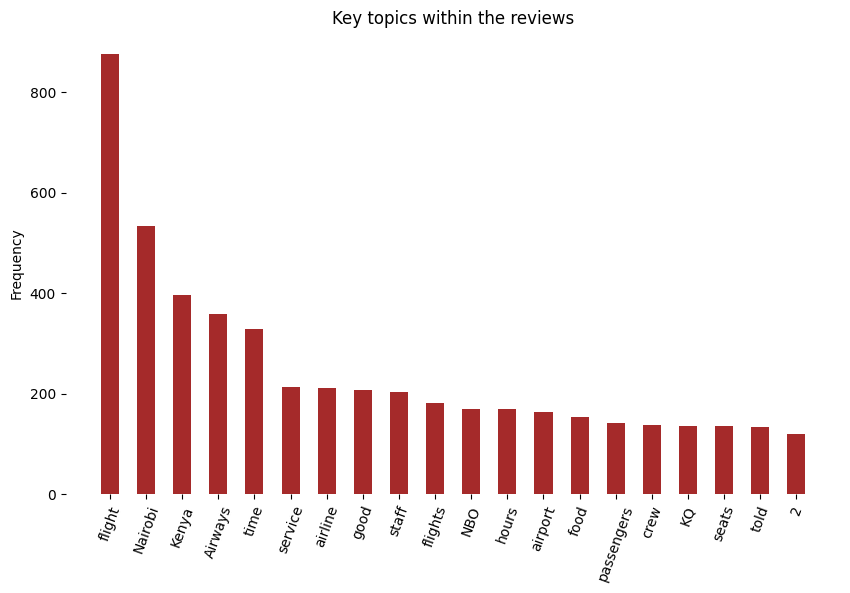

In [46]:
import matplotlib.pyplot as plt

# Create the bar plot directly from the Counter object
plt.figure(figsize=(10, 6))
plt.bar(*zip(*word_counts.most_common(20)), width=0.5, edgecolor='none', color='brown')
plt.ylabel('Frequency')
plt.title('Key topics within the reviews')
plt.xticks(rotation=70)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.show()

The frequency chart shows that the key topics within the reviews include 
1. Time
2. Service
3. Good
4. Staff
5. Hours   
 
People are actively talking about their experience and staff.

Next we use the vaderSentiment library to calculate the emotional score of each review which ranges from -1 (negative sentiment) to 1 (positive sentiment)

In [47]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the VADER SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Function to perform sentiment analysis using VADER
def perform_sentiment_analysis(text):
    sentiment_score = analyzer.polarity_scores(text)
    return sentiment_score['compound']

# Apply sentiment analysis to the 'reviews' column and create a new column 'sentiment_score'
df['sentiment_score'] = df['reviews'].apply(perform_sentiment_analysis)

# Function to classify sentiment as positive, negative, or neutral
def classify_sentiment(sentiment_score):
    if sentiment_score > 0:
        return 'Positive'
    elif sentiment_score < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment classification function to create a new column 'sentiment_label'
df['sentiment_label'] = df['sentiment_score'].apply(classify_sentiment)

df.head()

,reviews,sentiment_score,sentiment_label
0,Dismal from start to end. Not all of the s...,-0.9767,Negative
1,Airline was 1 hour late to board passengers ...,-0.8899,Negative
2,Kenya Airways has really disappointed me f...,-0.2952,Negative
3,JNB-NBO-AMS-ZRH on 14-15 August 23. Flight...,0.9440,Positive
4,Officially the worlds worst airline. 3hr + ...,-0.9690,Negative


### 5.2 <span class="anchor" id="2.2">Results<span>

Concluding our analysis, a gauge chart to visually illustrate customer satisfaction.

In [48]:
import plotly.graph_objects as go

# Calculate the counts of positive and negative sentiments
positive_count = df[df['sentiment_label'] == 'Positive'].shape[0]
negative_count = df[df['sentiment_label'] == 'Negative'].shape[0]
total = positive_count + negative_count


# Calculate the percentage of positive and negative sentiments
positive_percentage = (positive_count / total) * 100
negative_percentage = (negative_count / total) * 100

fig = go.Figure(go.Indicator(
    mode="gauge+number",
    value=positive_percentage,  # Set the positive sentiment percentage here
    domain={'x': [0, 1], 'y': [0, 1]},
    title={'text': "Customer Satisfaction"},
    gauge={'axis': {'range': [0, 100]},  # Set the axis range to 0-100 for percentage
           'bar': {'color': "blue"},
           'bgcolor': "white",
           'borderwidth': 2,
           'bordercolor': "gray"},
           number={'suffix': "%", 'valueformat': '.0f'}))

# # Add an annotation to label the "Positive" end of the gauge
# fig.add_annotation(text="Positive", x=0.695, y=0.03,
#                    xanchor="left", yanchor="middle",
#                    showarrow=False, font=dict(size=25))

fig.show()

In [49]:
print(f"Out of {total} reviews, {positive_count} were positive and {negative_count} were negative.")

Out of 433 reviews, 210 were positive and 223 were negative.


In [50]:
import session_info

session_info.show()
